In [1]:
%run 'Functions.ipynb'

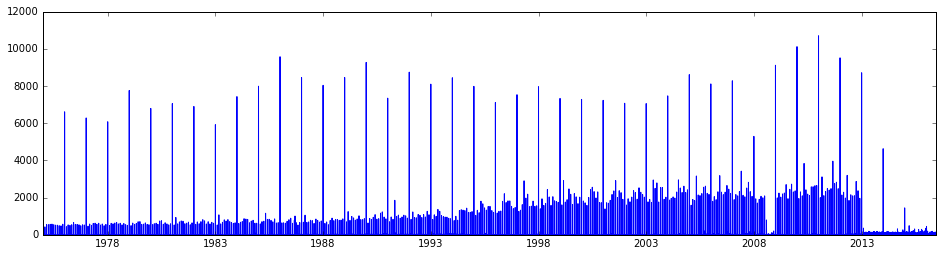

In [2]:
x, y = unzip(hist_data(None, '1975-01-01', '2017-01-01'))
plt.plot(x, y)

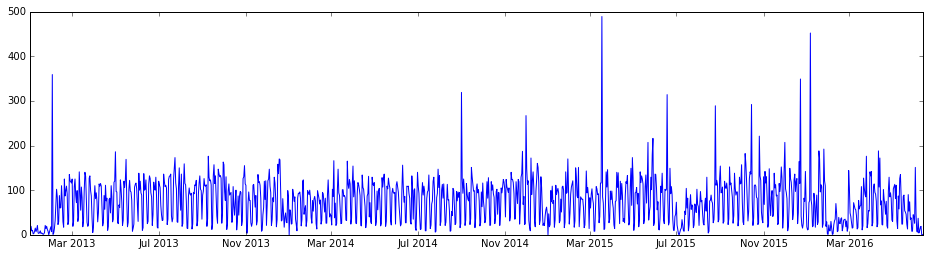

In [3]:
x, y = unzip(hist_data(None, '2013-01-01', '2017-01-01'))
y[y >= 1000] = 0
plt.plot(x, y)

In [4]:
def hist_data_precise(terms=None, start='1900-01-01', end='2020-01-01', show_query=False):
    q = Search(index='hep-slim')[0:0] \
        .filter("script", script="d = doc['earliest_date'].date; d.getDayOfMonth() != 1") \
        .filter('range', earliest_date={'gte': start, 'lt': end})
    q.aggs.bucket(
        'group_by_date',
        'date_histogram',
        field='earliest_date',
        interval='day',
        format='date_optional_time'
    )
    if terms:
        q = q.query('match', abstract=terms)
    if show_query:
        print(q.to_dict())
    return q.execute().aggregations.group_by_date.buckets

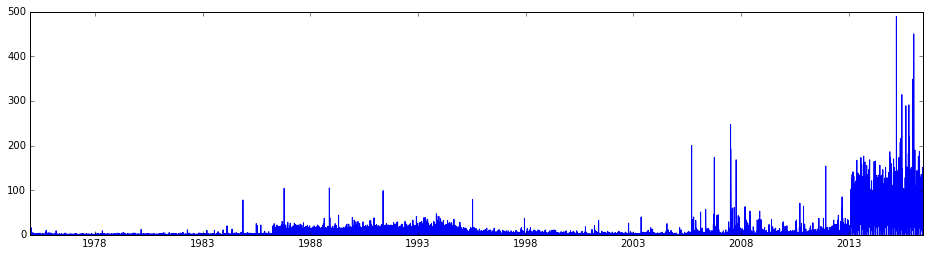

In [5]:
x, y = unzip(hist_data_precise(None, '1975-01-01', '2017-01-01'))
plt.plot(x, y)

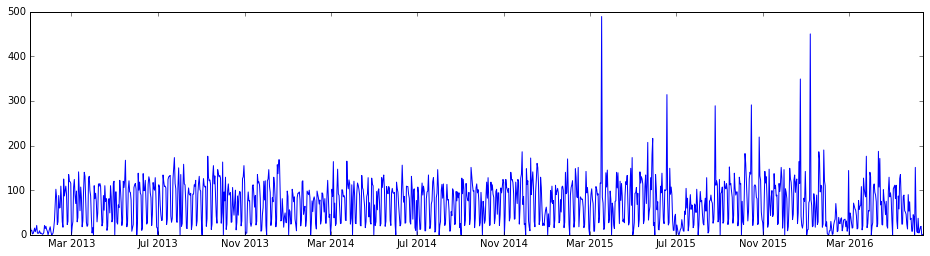

In [6]:
x, y = unzip(hist_data_precise(None, '2013-01-01', '2017-01-01'))
plt.plot(x, y)

In [7]:
sum(y)

89947

In [8]:
def reverse_date_references(show_query=False):
    '''Builds a reverse index from recid to the minimum dates of papers referring this recid.'''
    
    q = Search(index='hep-slim')[0:0] \
        .filter("script", script="d = doc['earliest_date'].date; d.getDayOfMonth() != 1")
    agg = q.aggs.bucket(
        'references',
        'terms',
        field='references.recid',
        size=0
    )
    agg.bucket('min_earliest_date', 'min', field='earliest_date')
    agg.bucket('min_preprint_date', 'min', field='preprint_date')
    agg.bucket('min_modification_date', 'min', field='creation_modification_date.modification_date')
    agg.bucket('min_creation_date', 'min', field='creation_modification_date.creation_date')
    if show_query:
        print(q.to_dict())
    res = q.execute().aggregations.references.buckets
    
    def extract_date(elem):
        return parse_iso_date(elem.value_as_string) if "value_as_string" in elem else None
    
    mappings = {}
    for elem in res:
        mappings[elem.key] = {
            'earliest_date': extract_date(elem.min_earliest_date),
            'preprint_date': extract_date(elem.min_preprint_date), # may be missing
            'modification_date': extract_date(elem.min_modification_date),
            'creation_date': extract_date(elem.min_creation_date)
        }
    return mappings

In [9]:
recid_min_date_index = reverse_date_references()

In [10]:
# missing preprint date
len([e for e in list(recid_min_date_index.values()) if e['preprint_date'] is None])

15396

In [11]:
len(recid_min_date_index.keys())

219714

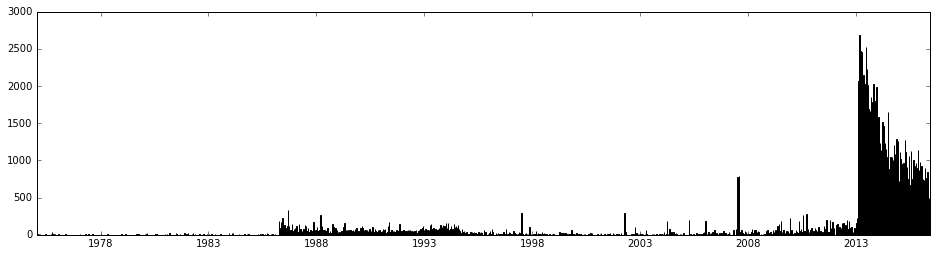

In [12]:
plt.hist([e['earliest_date'] for e in recid_min_date_index.values()], bins=2000)
plt.show()

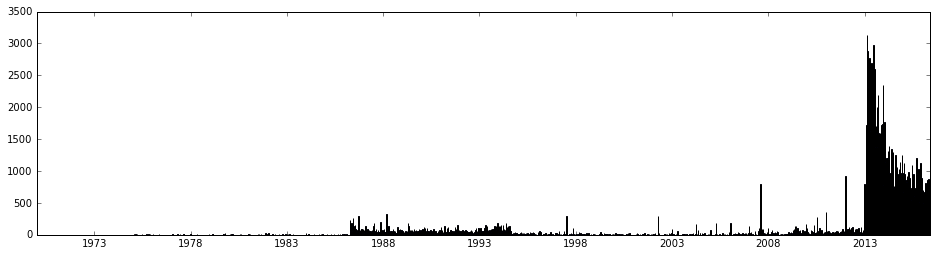

In [13]:
plt.hist([e['preprint_date'] for e in recid_min_date_index.values() if e['preprint_date'] is not None], bins=2000)
plt.show()

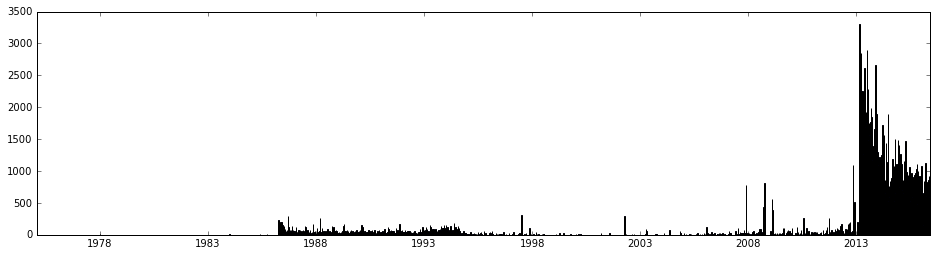

In [14]:
plt.hist([e['modification_date'] for e in recid_min_date_index.values()], bins=2000)
plt.show()

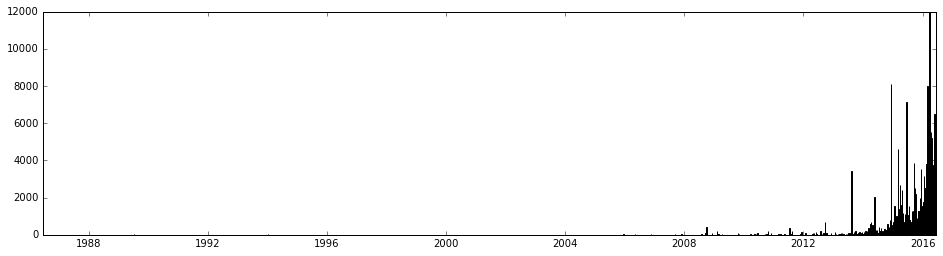

In [15]:
plt.hist([e['creation_date'] for e in recid_min_date_index.values()], bins=2000)
plt.show()

In [16]:
def precise_recid(show_query=False):
    '''Retrieves recid and precise earliest date.'''
    
    q = Search(index='hep-slim') \
        .fields(['self_recid', 'earliest_date']) \
        .filter("script", script="d = doc['earliest_date'].date; d.getDayOfMonth() != 1")
    if show_query:
        print(q.to_dict())
    res = []
    for hit in q.scan():
        res.append((hit.self_recid[0], datetime.strptime(hit.earliest_date[0], '%Y-%m-%d')))
    return res

In [17]:
precise = precise_recid()
len(precise)

130758

In [18]:
relocated = set(recid_min_date_index.keys())
new_relocated_recid = relocated.difference(set([e[0] for e in precise]))
len(new_relocated_recid)

183130

In [19]:
len(new_relocated_recid) / len(relocated) * 100

83.34926313298196

In [20]:
diffs = []
for recid, earliest_date in precise:
    if recid in recid_min_date_index:
        relocation = recid_min_date_index[recid]
        delta = relocation['earliest_date'].timestamp() - earliest_date.timestamp()
        delta /= 24 * 60 * 60
        diffs.append(delta)

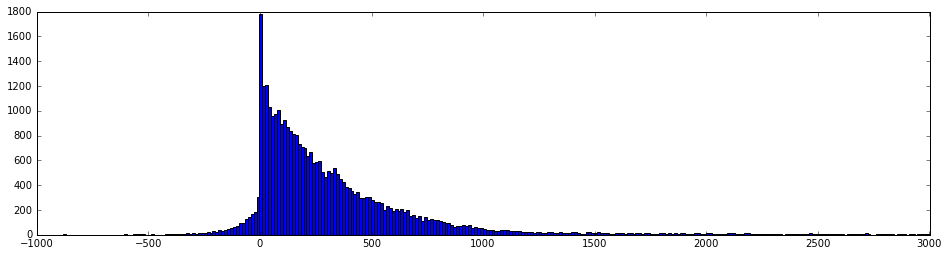

In [21]:
plt.hist(diffs, bins=2000)
plt.xlim(-1000, 3000)
plt.show()

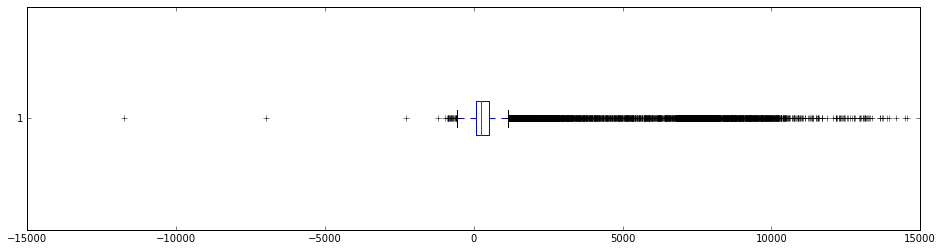

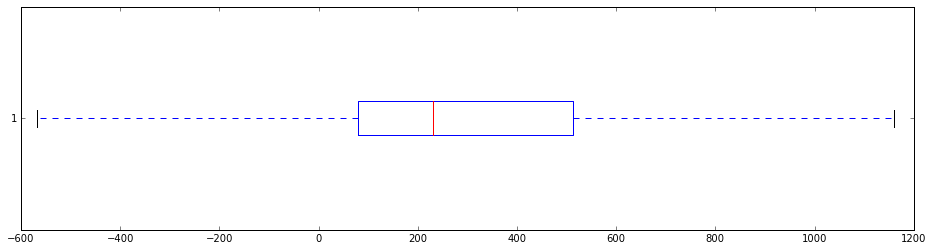

In [22]:
plt.boxplot(diffs, vert=False)
plt.show()
plt.boxplot(diffs, vert=False, sym='')
plt.show()

In [23]:
len(diffs)

36584

In [24]:
np.std(diffs)

1796.7487759190412

In [25]:
np.mean(diffs)

750.12624940775572

In [26]:
sp.stats.percentileofscore(diffs, 0)

5.6431773452875573

In [27]:
np.percentile(diffs, 94)

3107.0816666666601

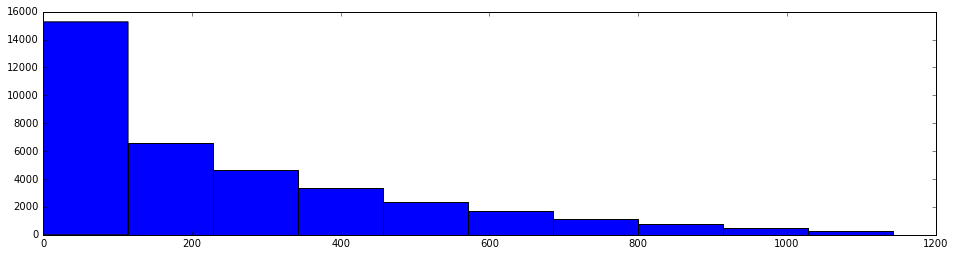

In [28]:
diffs_sign = np.array(diffs)
diffs_sign[diffs_sign < 0] = 0
diffs_sign[diffs_sign > np.percentile(diffs, 90)] = 0
plt.hist(diffs_sign)
plt.show()

In [29]:
np.mean(diffs_sign)

240.23316659377505

In [30]:
np.std(diffs_sign)

250.14860294258918

In [31]:
np.count_nonzero(diffs_sign)

30618

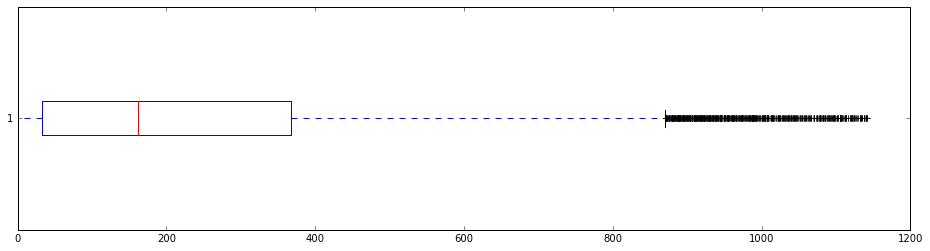

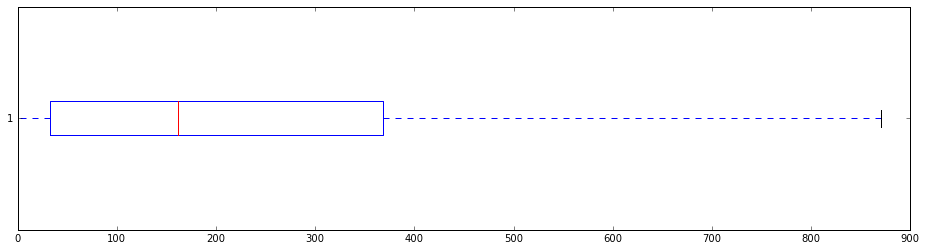

In [32]:
plt.boxplot(diffs_sign, vert=False)
plt.show()
plt.boxplot(diffs_sign, vert=False, sym='')
plt.show()